In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


DESCRIPTION

Artificial Intelligence has evolved a lot and is currently able to solve problems that are very complex and require human specialization. One such area is healthcare.

 

A lot of research happens every day to use deep learning for the betterment of humanity, and one such is healthcare.

 

Objective:   

To build a model using a convolutional neural network that can classify lung infection in a person using medical imagery

 

Dataset Description:

The dataset contains three different classes, including healthy, type 1 disease, and type 2 disease.

 

    Train folder: This folder has images for training the model, which is divided into subfolders having the same name as the class. 

    Test folder: This folder has images for testing the model, which is divided into subfolders having the same name as the class.

 

Following operations should be performed using Keras or PyTorch or Torch vision-   

    Import the necessary libraries

    Plot the sample images for all the classes 

    Plot the distribution of images across the classes

    Build a data augmentation for train data to create new data with translation, rescale and flip, and rotation transformations. Rescale the image at 48x48

    Build a data augmentation for test data to create new data and rescale the image at 48x48

    Read images directly from the train folder and test folder using the appropriate function

 

In [ ]:
import os
import time
import cv2
from google.colab.patches import cv2_imshow
import pickle
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [ ]:
def preprocess(image_path, train, image_size):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image/255
    return image

In [ ]:
def get_data(data_dir, train=True, image_size=48):
    data = [] 
    labels = []
    if train:
        path = os.path.join(data_dir, 'train')
    else:
        path = os.path.join(data_dir, 'test')
    for folder in os.listdir(path):
        if folder == ".DS_Store":
            continue
        image_dir = os.path.join(path, folder)
        for image in os.listdir(image_dir):
            if image == ".DS_Store":
                continue
            image_path = os.path.join(image_dir, image)
            
            image = preprocess(image_path, train, image_size)
            data.append(image)
            labels.append([folder])
    if train:
        datagen = ImageDataGenerator(
            rotation_range = 20,
            shear_range = 0.1,
            zoom_range = 0.1,
            horizontal_flip = False,)
        datagen.fit(data)
    return np.array(data), np.array(labels)

In [ ]:
train_images, train_labels = get_data('/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data')
test_images, test_labels = get_data('/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data', train=False)
print(train_images.shape)
print(test_images.shape)

(251, 48, 48, 3)
(66, 48, 48, 3)


In [ ]:
def show_rnd_images(images, labels):
    fig, ax = plt.subplots(5, 5, figsize=(25,25))
    for i in range(5):
        for j in range(5):
            rnd_int = rnd.randint(0, len(images)-1)
            ax[i,j].imshow(images[rnd_int],cmap='gray')
            ax[i,j].axis("off")
            ax[i,j].title.set_text(labels[rnd_int][0])
    plt.show()

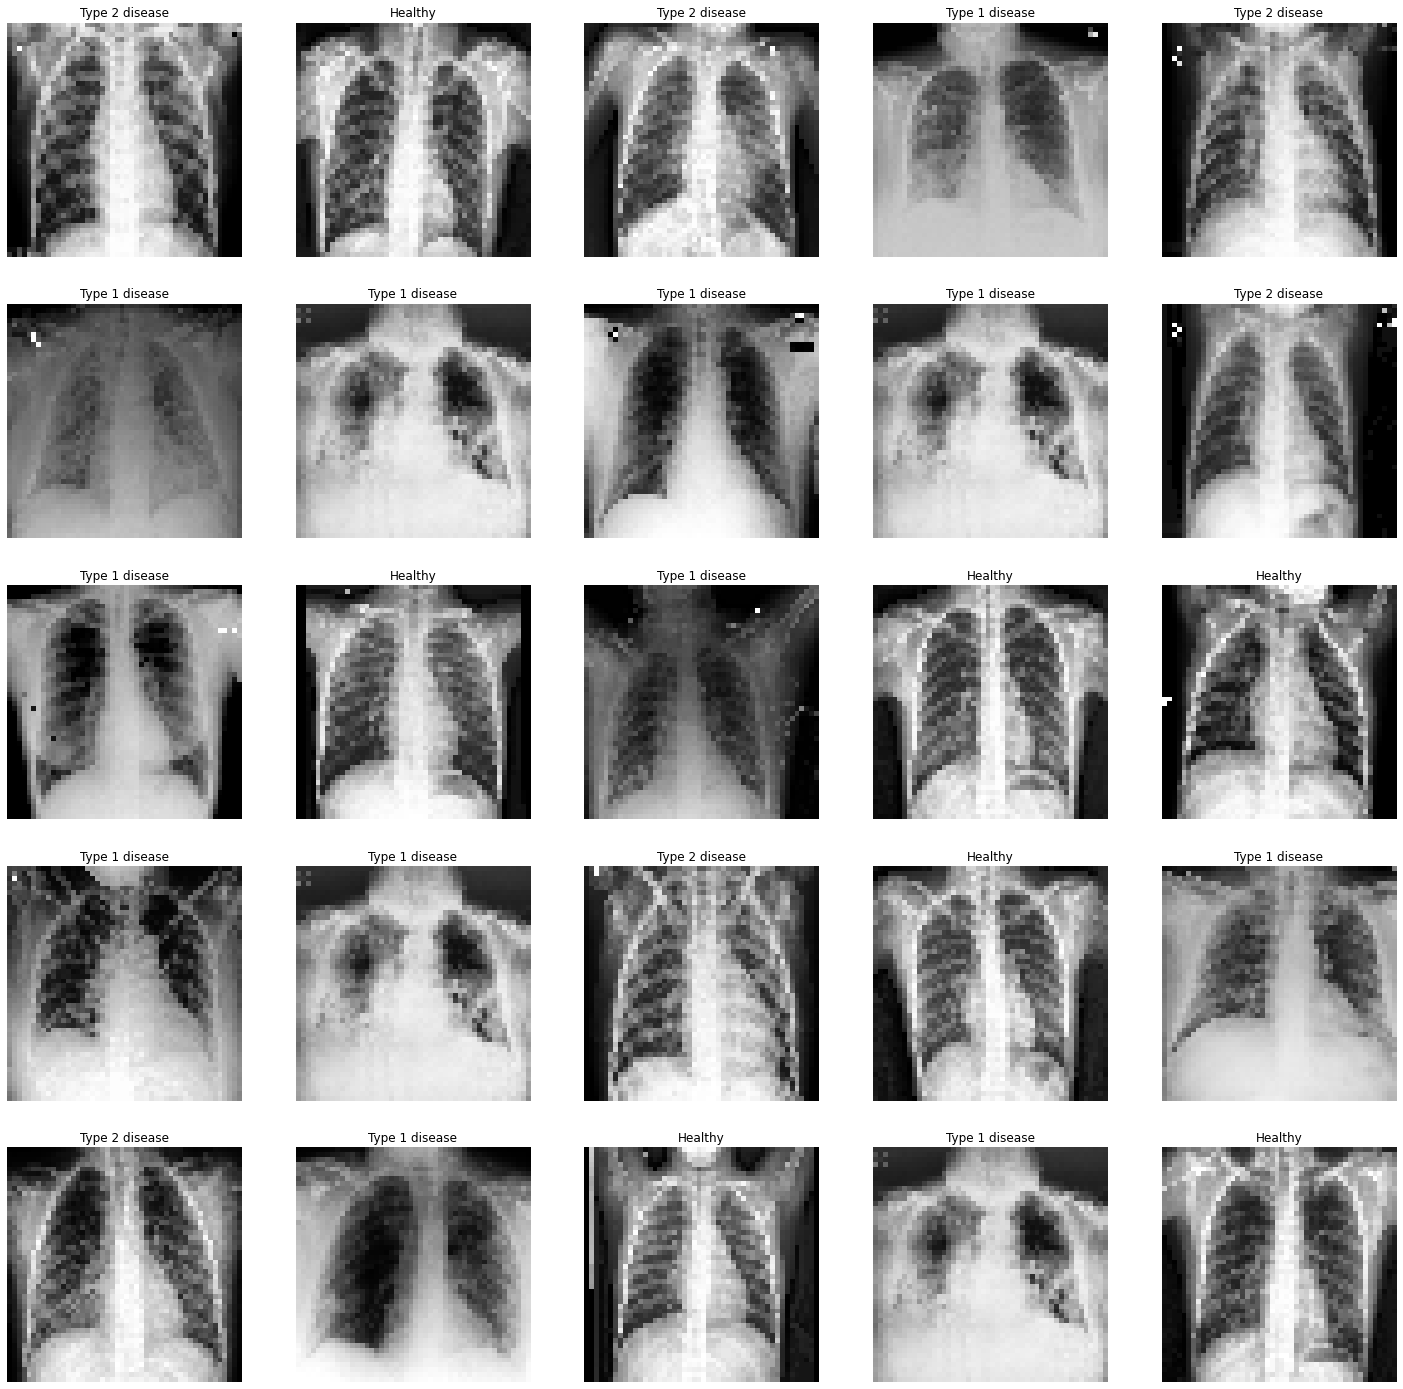

In [ ]:
show_rnd_images(train_images, train_labels)

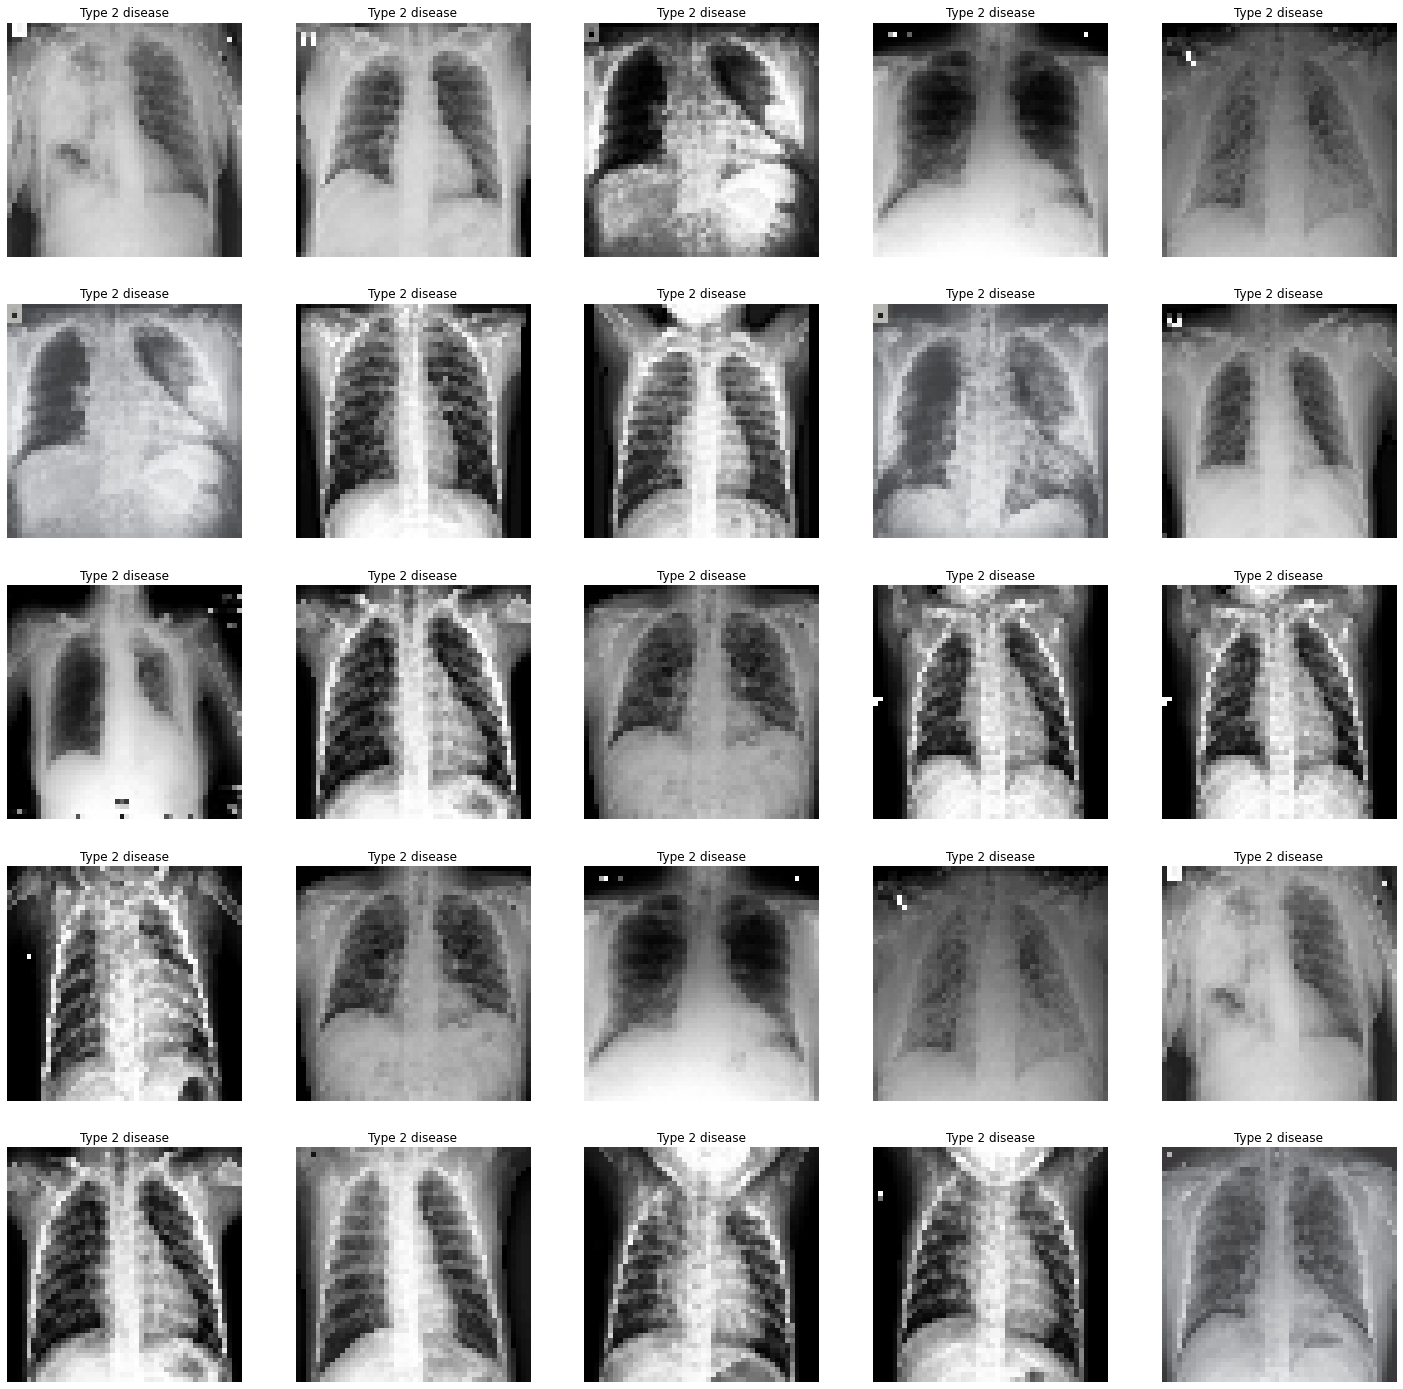

In [ ]:
# Show test Images
show_rnd_images(test_images, train_labels)

In [ ]:
train_images, train_labels = get_data('/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data')
test_images, test_labels = get_data('/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data', train=False)
print(train_images.shape)
print(test_images.shape)

(251, 48, 48, 3)
(66, 48, 48, 3)


In [ ]:
# Change healthy to Healthy label in Test labels
train_labels[train_labels == ["Healthy"]] = ['Healthy']
test_labels[test_labels == ["Healthy"]] = ['Healthy']

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
train_labels = enc.fit_transform(train_labels).toarray()
test_labels = enc.transform(test_labels).toarray()

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=train_images.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())  

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=[keras.metrics.AUC(from_logits=True)])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        9232      
                                                                 
 activation_1 (Activation)   (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                    

In [ ]:
history = model.fit(train_images, train_labels, 
                    validation_data=(test_images, test_labels), 
                    epochs=40)

Epoch 1/40
8/8 [==============================] - 2s 196ms/step - loss: 1.0783 - auc: 0.5904 - val_loss: 1.0101 - val_auc: 0.7150
Epoch 2/40
8/8 [==============================] - 1s 161ms/step - loss: 0.9426 - auc: 0.7145 - val_loss: 0.7552 - val_auc: 0.8722
Epoch 3/40
8/8 [==============================] - 1s 158ms/step - loss: 0.6970 - auc: 0.8215 - val_loss: 0.5915 - val_auc: 0.9034
Epoch 4/40
8/8 [==============================] - 1s 157ms/step - loss: 0.5687 - auc: 0.8709 - val_loss: 0.5398 - val_auc: 0.8988
Epoch 5/40
8/8 [==============================] - 2s 197ms/step - loss: 0.4817 - auc: 0.8996 - val_loss: 0.6049 - val_auc: 0.8850
Epoch 6/40
8/8 [==============================] - 3s 329ms/step - loss: 0.4122 - auc: 0.9194 - val_loss: 0.4500 - val_auc: 0.9284
Epoch 7/40
8/8 [==============================] - 2s 317ms/step - loss: 0.3654 - auc: 0.9328 - val_loss: 0.4290 - val_auc: 0.9286
Epoch 8/40
8/8 [==============================] - 3s 360ms/step - loss: 0.3258 - auc: 0.94

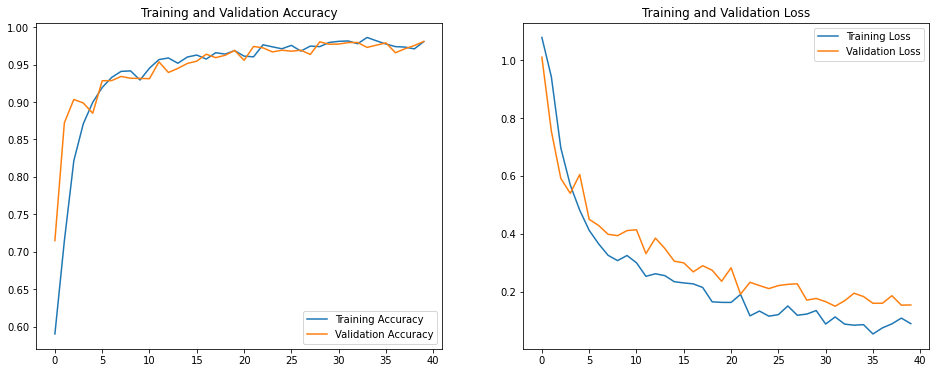

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Training Accuracy')
plt.plot(history.history['val_auc'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def prediction(images):
    y_pred = []
    for i in model.predict(images).argmax(axis=1):
        tmp = [0., 0., 0.]
        tmp[i] = 1.
        y_pred.append(tmp)
    y_pred = enc.inverse_transform(y_pred)
    return y_pred

In [ ]:
y_pred = prediction(test_images)

3/3 [==============================] - 0s 21ms/step


In [ ]:
y_true = enc.inverse_transform(test_labels)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

0.9393939393939394
                precision    recall  f1-score   support

       Healthy       0.95      0.90      0.92        20
Type 1 disease       0.96      0.96      0.96        26
Type 2 disease       0.90      0.95      0.93        20

      accuracy                           0.94        66
     macro avg       0.94      0.94      0.94        66
  weighted avg       0.94      0.94      0.94        66



array([[18,  0,  2],
       [ 1, 25,  0],
       [ 0,  1, 19]])

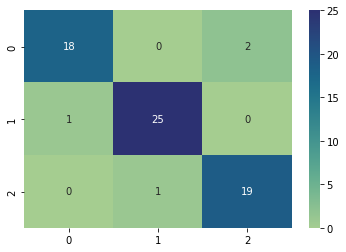

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True,fmt='d',cmap= "crest")

In [ ]:
model.evaluate(test_images, test_labels, batch_size=16)

5/5 [==============================] - 0s 17ms/step - loss: 0.1543 - auc: 0.9808


[0.15426717698574066, 0.9808310270309448]

In [ ]:
model.save("Lung Detection model.h5")

1/1 [==============================] - 0s 132ms/step


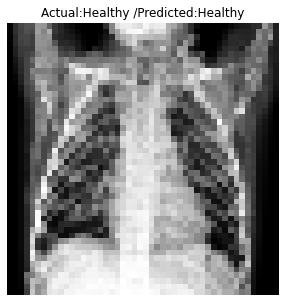

In [ ]:
# Loading the .h5 model that we had saved in the previous step:
my_xray_cnnmodel = keras.models.load_model("/content/Lung Detection model.h5")

# Defining an image path from the "pred" folder:
image_path = '/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data/test/Healthy/0107.jpeg'

# Preprocessing the image to 150x150x3 size and predicting the label:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(48,48,3))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = my_xray_cnnmodel.predict(input_arr)

classes = ['Healthy', 'Type 1 disease', 'Type 2 disease']

actual = ''

for class_name in classes:
    if class_name in image_path:
        actual = class_name

pred = classes[np.argmax(predictions, axis=1)[0]]

# Finally we are displaying the predicted outcome:
plt.figure(figsize=[8,5])
plt.imshow(image, cmap='gray')
#plt.title("Actual:"+actual+" /Predicted:"+pred, size=15)
plt.title(f"Actual:{actual} /Predicted:{pred}")
plt.axis('off')
plt.show()

In [ ]:
actual

''

#Transfer learning using DenseNet121:

 

    Prepare data for the pre-trained mobile net model, with color mode as RGB

    Create an instance of a mobile net pre-trained model 

    Add dense layer, dropout layer, batch normalization layer on the pre-trained model

    Create a final output layer with a SoftMax activation function

    Change the batch size activation function and optimize as rmsprop and observe if the accuracy increases

    Take the loss function as categorical cross-entropy

    Use early stopping with the patience of two epoch and call back function for preventing overfitting

    Try with ten numbers epoch

    Train the model using a generator and test the accuracy of the test data at every epoch

     Plot the training and validation accuracy, and the loss

     Observe the precision, recall the F1-score for all classes for both grayscale

    and color models, and determine if the model’s classes are good


In [ ]:
#import necessary librabry
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import os
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#defining the base, train and validation directory path
train_dir = os.path.join('/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data/train')
test_dir = os.path.join('/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data/test')

In [ ]:
#defining the damage and whole , train nand validation directory
train_Healthy_dir = os.path.join(train_dir, 'Healthy')
train_T1_dir = os.path.join(train_dir, 'Type 1 disease')
train_T2_dri = os.path.join(train_dir, 'Type 2 disease')
test_Healthy_dir = os.path.join(test_dir, 'Healthy')
test_T1_dir = os.path.join(test_dir, 'Type 1 disease')
test_T2_dri = os.path.join(test_dir, 'Type 2 disease')

In [ ]:
#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224), 
        batch_size=15,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=15,
        class_mode='categorical')

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [ ]:
from tensorflow.keras import Model 
from tensorflow.keras.applications import DenseNet121   

base_model = DenseNet121(input_shape = (224, 224, 3),  include_top = False, weights = 'imagenet') 

x=   tf.keras.layers.Flatten()(base_model.output)
x=   tf.keras.layers.Dense(512, activation='relu')(x) 
x=   tf.keras.layers.Dropout(0.5)(x)
x=   tf.keras.layers.Dense(64, activation='relu')(x)
x=   tf.keras.layers.Dense(3, activation='softmax')(x) 

model1= Model(base_model.input, x)

model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['Accuracy','Precision','Recall'])

#training the model
history = model1.fit(
      train_generator,
      epochs=15,
      validation_data=validation_generator,
      verbose=2)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
17/17 - 274s - loss: 1.1153 - Accuracy: 0.6972 - precision: 0.7049 - recall: 0.6853 - val_loss: 2.4994 - val_Accuracy: 0.1212 - val_precision: 0.0968 - val_recall: 0.0909 - 274s/epoch - 16s/step
Epoch 2/15
17/17 - 236s - loss: 0.3150 - Accuracy: 0.9323 - precision: 0.9360 - recall: 0.9323 - val_loss: 5.0268 - val_Accuracy: 0.2121 - val_precision: 0.2031 - val_recall: 0.1970 - 236s/epoch - 14s/step
Epoch 3/15
17/17 - 220s - loss: 0.1372 - Accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - val_loss: 6.6807 - val_Accuracy: 0.1515 - val_precision: 0.1515 - val_recall: 0.1515 - 220s/epoch - 13s/step
Epoch 4/15
17/17 - 219s - loss: 0.1759 - Accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - val_loss: 8.1865 - val_Accuracy: 0.2121 - val_precision: 0.2121 - val_recall: 0.2121 - 219s/epoch - 13s/step
Epoch 5/15
17/17 - 215s - loss: 0.0627 - Accuracy: 0.9880 - precision: 0.9880 - recall: 0.9841 - val_loss: 10.8670 - val_Accuracy: 0.2273 - val_precision: 0.2273 - val_recall: 

In [ ]:
#weights saving
model1.save("mobile_net classifier.h5")

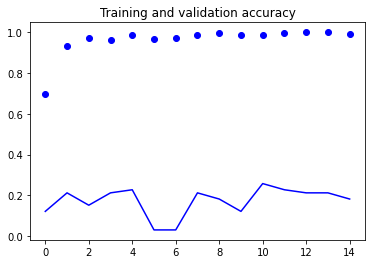

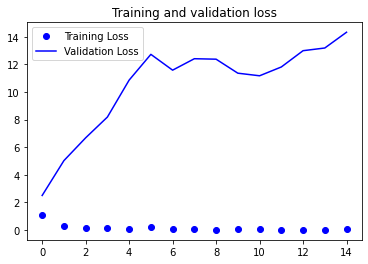

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

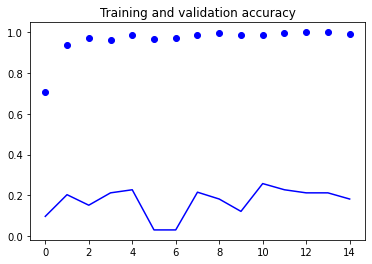

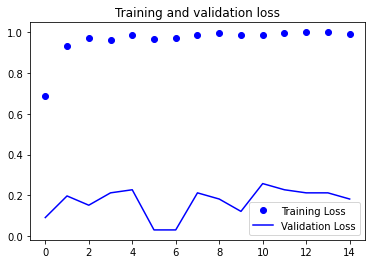

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['precision']
val_acc = history.history['val_precision']
loss = history.history['recall']
val_loss = history.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def get_data_224(data_dir, train=True, image_size=224):
    data = [] 
    labels = []
    if train:
        path = os.path.join(data_dir, 'train')
    else:
        path = os.path.join(data_dir, 'test')
    for folder in os.listdir(path):
        if folder == ".DS_Store":
            continue
        image_dir = os.path.join(path, folder)
        for image in os.listdir(image_dir):
            if image == ".DS_Store":
                continue
            image_path = os.path.join(image_dir, image)
            
            image = preprocess(image_path, train, image_size)
            data.append(image)
            labels.append([folder])
    if train:
        datagen = ImageDataGenerator(
            rotation_range = 20,
            shear_range = 0.1,
            zoom_range = 0.1,
            horizontal_flip = False,)
        datagen.fit(data)
    return np.array(data), np.array(labels)

In [ ]:
train_images, train_labels2 = get_data_224('/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data')
test_images, test_labels2 = get_data_224('/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data', train=False)
print(train_images.shape)
print(test_images.shape)

(251, 224, 224, 3)
(66, 224, 224, 3)


In [ ]:
# Change healthy to Healthy label in Test labels
test_labels2[test_labels2 == ["healthy"]] = ['Healthy']

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
train_labels = enc.fit_transform(train_labels2).toarray()
test_labels = enc.transform(test_labels2).toarray()

In [ ]:
def prediction_m(images):
    y_pred = []
    for i in model1.predict(images).argmax(axis=1):
        tmp = [0., 0., 0.]
        tmp[i] = 1.
        y_pred.append(tmp)
    y_pred = enc.inverse_transform(y_pred)
    return y_pred

In [ ]:
y_pred_m = prediction_m(test_images)

3/3 [==============================] - 12s 2s/step


In [ ]:
y_true_m = enc.inverse_transform(test_labels)

0.8181818181818182
                precision    recall  f1-score   support

       Healthy       1.00      0.50      0.67        20
Type 1 disease       0.93      1.00      0.96        26
Type 2 disease       0.64      0.90      0.75        20

      accuracy                           0.82        66
     macro avg       0.86      0.80      0.79        66
  weighted avg       0.86      0.82      0.81        66



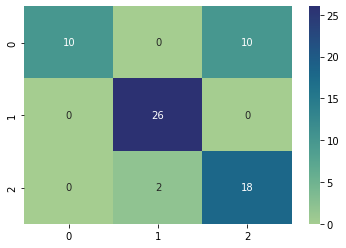

In [ ]:
print(accuracy_score(y_true_m, y_pred_m))
print(classification_report(y_true_m, y_pred_m))
confusion_matrix(y_true_m, y_pred_m)

sns.heatmap(confusion_matrix(y_true_m, y_pred_m),annot=True,fmt='d',cmap= "crest")

1/1 [==============================] - 2s 2s/step


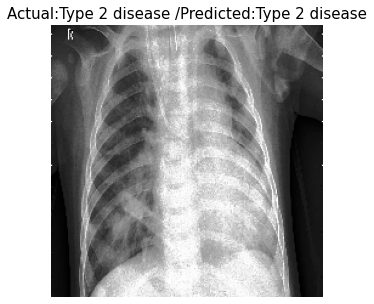

In [ ]:
# Loading the .h5 model that we had saved in the previous step:
my_xray_cnnmodel = tf.keras.models.load_model("/content/mobile_net classifier.h5")

# Defining an image path from the "pred" folder:
image_path = '/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data/test/Type 2 disease/0110.jpeg'

# Preprocessing the image to 150x150x3 size and predicting the label:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224,224,3))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = my_xray_cnnmodel.predict(input_arr)

classes = ['Healthy', 'Type 1 disease', 'Type 2 disease']

actual = ''

for class_name in classes:
    if class_name in image_path:
        actual = class_name

pred = classes[np.argmax(predictions, axis=1)[0]]

# Finally we are displaying the predicted outcome:
plt.figure(figsize=[8,5])
plt.imshow(image)
plt.title("Actual:"+actual+" /Predicted:"+pred, size=15)
plt.axis('off')
plt.show()



#Transfer Learning using MObile Net:

 

    Prepare the dataset for the transfer learning algorithm using Densenet121 with the image size as 224x224x3

    Freeze the top layers of the pre-trained model

    Add a dense layer at the end of the pre-trained model followed by a dropout layer and try various combinations to get an accuracy

    Add the final output layer with a SoftMax activation function

    Take loss function as categorical cross-entropy

    Take Adam as an optimizer

    Use early stopping to prevent overfitting

    Try with 15 number of epoch and batch size with seven, also try various values to see the impact on results

    Train the model using the generator and test the accuracy of the test data at every epoch 

     Plot the training and validation accuracy, and the loss

    Observe the precision, recall the F1-score for all classes for both grayscale and color models, and determine if the model’s classes are good

 

Final step:   

    Compare all the models on the basis of accuracy, precision, recall, and f1-score


In [ ]:
from tensorflow.keras import Model 
from tensorflow.keras.applications import MobileNetV2  
IMG_SHAPE = (224,224,3)
base_model_1 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

In [ ]:
x=   tf.keras.layers.Flatten()(base_model_1.output)
x=   tf.keras.layers.Dense(512, activation='relu')(x) 
x=   tf.keras.layers.Dropout(0.5)(x)
x=   tf.keras.layers.Dense(64, activation='relu')(x)
x=   tf.keras.layers.Dense(3, activation='softmax')(x) 

model2= Model(base_model_1.input, x)

model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['Accuracy','Precision','Recall'])

#training the model
history = model2.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      verbose=2)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
17/17 - 73s - loss: 1.0551 - Accuracy: 0.7012 - precision: 0.7114 - recall: 0.6972 - val_loss: 3.5342 - val_Accuracy: 0.4545 - val_precision: 0.4462 - val_recall: 0.4394 - 73s/epoch - 4s/step
Epoch 2/10
17/17 - 64s - loss: 0.1884 - Accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - val_loss: 4.2614 - val_Accuracy: 0.3636 - val_precision: 0.3636 - val_recall: 0.3636 - 64s/epoch - 4s/step
Epoch 3/10
17/17 - 69s - loss: 0.2139 - Accuracy: 0.9442 - precision: 0.9438 - recall: 0.9363 - val_loss: 3.6835 - val_Accuracy: 0.4545 - val_precision: 0.4615 - val_recall: 0.4545 - 69s/epoch - 4s/step
Epoch 4/10
17/17 - 67s - loss: 0.0635 - Accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - val_loss: 3.9313 - val_Accuracy: 0.3939 - val_precision: 0.4062 - val_recall: 0.3939 - 67s/epoch - 4s/step
Epoch 5/10
17/17 - 66s - loss: 0.0457 - Accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - val_loss: 5.9249 - val_Accuracy: 0.4242 - val_precision: 0.4242 - val_recall: 0.4242 - 66s/e

In [ ]:
#weights saving
model2.save("Densenet121_classifier_m.h5")

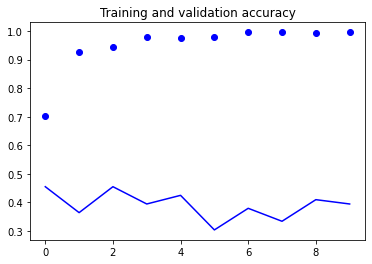

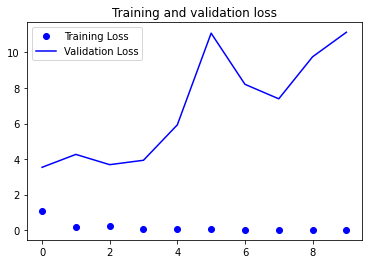

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

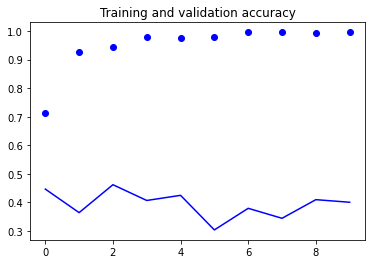

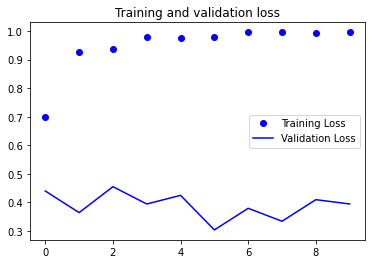

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['precision']
val_acc = history.history['val_precision']
loss = history.history['recall']
val_loss = history.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def prediction_m2(images):
    y_pred = []
    for i in model2.predict(images).argmax(axis=1):
        tmp = [0., 0., 0.]
        tmp[i] = 1.
        y_pred.append(tmp)
    y_pred = enc.inverse_transform(y_pred)
    return y_pred

In [ ]:
y_pred_m2 = prediction_m2(test_images)

3/3 [==============================] - 2s 580ms/step


In [ ]:
y_true_m2 = enc.inverse_transform(test_labels)

0.8939393939393939
                precision    recall  f1-score   support

       Healthy       1.00      0.75      0.86        20
Type 1 disease       0.93      1.00      0.96        26
Type 2 disease       0.78      0.90      0.84        20

      accuracy                           0.89        66
     macro avg       0.90      0.88      0.89        66
  weighted avg       0.91      0.89      0.89        66



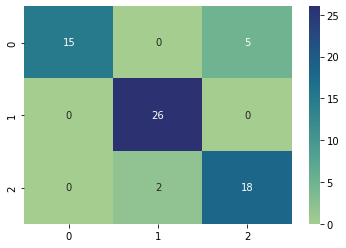

In [ ]:
print(accuracy_score(y_true_m, y_pred_m))
print(classification_report(y_true_m, y_pred_m))
confusion_matrix(y_true_m, y_pred_m)

sns.heatmap(confusion_matrix(y_true_m, y_pred_m),annot=True,fmt='d',cmap= "crest")

1/1 [==============================] - 1s 942ms/step


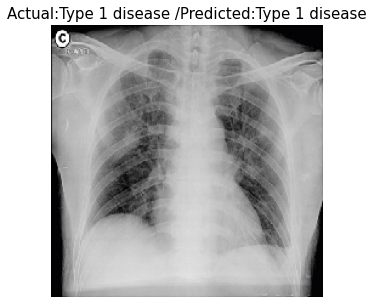

In [ ]:
# Loading the .h5 model that we had saved in the previous step:
my_xray_cnnmodel = tf.keras.models.load_model("/content/Densenet121_classifier_m.h5")

# Defining an image path from the "pred" folder:
image_path = '/content/MyDrive/MyDrive/Adv Deep Learning Image Recognition/Dataset_Detection_of_Lung_Infection/data/test/Type 1 disease/0120.jpg'

# Preprocessing the image to 150x150x3 size and predicting the label:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224,224,3))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = my_xray_cnnmodel.predict(input_arr)

classes = ['Healthy', 'Type 1 disease', 'Type 2 disease']

actual = ''

for class_name in classes:
    if class_name in image_path:
        actual = class_name

pred = classes[np.argmax(predictions, axis=1)[0]]

# Finally we are displaying the predicted outcome:
plt.figure(figsize=[8,5])
plt.imshow(image)
plt.title("Actual:"+actual+" /Predicted:"+pred, size=15)
plt.axis('off')
plt.show()